In [1]:
### Define our Connector

import requests,os,time
def ratelimit(dt):
    "A function that handles the rate of your calls."
    time.sleep(dt) # sleep one second.

class Connector():
  def __init__(self,logfile,overwrite_log=False,connector_type='requests',session=False,path2selenium='',n_tries = 5,timeout=30,waiting_time=0.5):
    """This Class implements a method for reliable connection to the internet and monitoring. 
    It handles simple errors due to connection problems, and logs a range of information for basic quality assessments
    
    Keyword arguments:
    logfile -- path to the logfile
    overwrite_log -- bool, defining if logfile should be cleared (rarely the case). 
    connector_type -- use the 'requests' module or the 'selenium'. Will have different since the selenium webdriver does not have a similar response object when using the get method, and monitoring the behavior cannot be automated in the same way.
    session -- requests.session object. For defining custom headers and proxies.
    path2selenium -- str, sets the path to the geckodriver needed when using selenium.
    n_tries -- int, defines the number of retries the *get* method will try to avoid random connection errors.
    timeout -- int, seconds the get request will wait for the server to respond, again to avoid connection errors.
    """
    
    ## Initialization function defining parameters. 
    self.n_tries = n_tries # For avoiding triviel error e.g. connection errors, this defines how many times it will retry.
    self.timeout = timeout # Defining the maximum time to wait for a server to response.
    self.waiting_time = waiting_time # define simple rate_limit parameter.
    ## not implemented here, if you use selenium.
    if connector_type=='selenium':
      assert path2selenium!='', "You need to specify the path to you geckodriver if you want to use Selenium"
      from selenium import webdriver 
      ## HIN download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases

      assert os.path.isfile(path2selenium),'You need to insert a valid path2selenium the path to your geckodriver. You can download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases'
      self.browser = webdriver.Firefox(executable_path=path2selenium) # start the browser with a path to the geckodriver.

    self.connector_type = connector_type # set the connector_type
    
    if session: # set the custom session
      self.session = session
    else:
      self.session = requests.session()
    self.logfilename = logfile # set the logfile path
    ## define header for the logfile
    header = ['id','project','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
    if os.path.isfile(logfile):        
      if overwrite_log==True:
        self.log = open(logfile,'w')
        self.log.write(';'.join(header))
      else:
        self.log = open(logfile,'a')
    else:
      self.log = open(logfile,'w')
      self.log.write(';'.join(header))
    ## load log 
    with open(logfile,'r') as f: # open file
        
      l = f.read().split('\n') # read and split file by newlines.
      ## set id
      if len(l)<=1:
        self.id = 0
      else:
        self.id = int(l[-1][0])+1
            
  def get(self,url,project_name):
    """Method for connector reliably to the internet, with multiple tries and simple error handling, as well as default logging function.
    Input url and the project name for the log (i.e. is it part of mapping the domain, or is it the part of the final stage in the data collection).
    
    Keyword arguments:
    url -- str, url
    project_name -- str, Name used for analyzing the log. Use case could be the 'Mapping of domain','Meta_data_collection','main data collection'. 
    """
     
    project_name = project_name.replace(';','-') # make sure the default csv seperator is not in the project_name.
    if self.connector_type=='requests': # Determine connector method.
      for _ in range(self.n_tries): # for loop defining number of retries with the requests method.
        ratelimit(self.waiting_time)
        t = time.time()
        try: # error handling 
          response = self.session.get(url,timeout = self.timeout) # make get call

          err = '' # define python error variable as empty assumming success.
          success = True # define success variable
          redirect_url = response.url # log current url, after potential redirects 
          dt = t - time.time() # define delta-time waiting for the server and downloading content.
          size = len(response.text) # define variable for size of html content of the response.
          response_code = response.status_code # log status code.
          ## log...
          call_id = self.id # get current unique identifier for the call
          self.id+=1 # increment call id
          #['id','project_name','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row to be written in the log.
          self.log.write('\n'+';'.join(map(str,row))) # write log.
          self.log.flush()
          return response,call_id # return response and unique identifier.

        except Exception as e: # define error condition
          err = str(e) # python error
          response_code = '' # blank response code 
          success = False # call success = False
          size = 0 # content is empty.
          redirect_url = '' # redirect url empty 
          dt = t - time.time() # define delta t

          ## log...
          call_id = self.id # define unique identifier
          self.id+=1 # increment call_id

          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row
          self.log.write('\n'+';'.join(map(str,row))) # write row to log.
          self.log.flush()
    else:
      t = time.time()
      ratelimit(self.waiting_time)
      self.browser.get(url) # use selenium get method
      ## log
      call_id = self.id # define unique identifier for the call. 
      self.id+=1 # increment the call_id
      err = '' # blank error message
      success = '' # success blank
      redirect_url = self.browser.current_url # redirect url.
      dt = t - time.time() # get time for get method ... NOTE: not necessarily the complete load time.
      size = len(self.browser.page_source) # get size of content ... NOTE: not necessarily correct, since selenium works in the background, and could still be loading.
      response_code = '' # empty response code.
      row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row 
      self.log.write('\n'+';'.join(map(str,row))) # write row to log file.
      self.log.flush()
    # Using selenium it will not return a response object, instead you should call the browser object of the connector.
    ## connector.browser.page_source will give you the html.
      return None,call_id

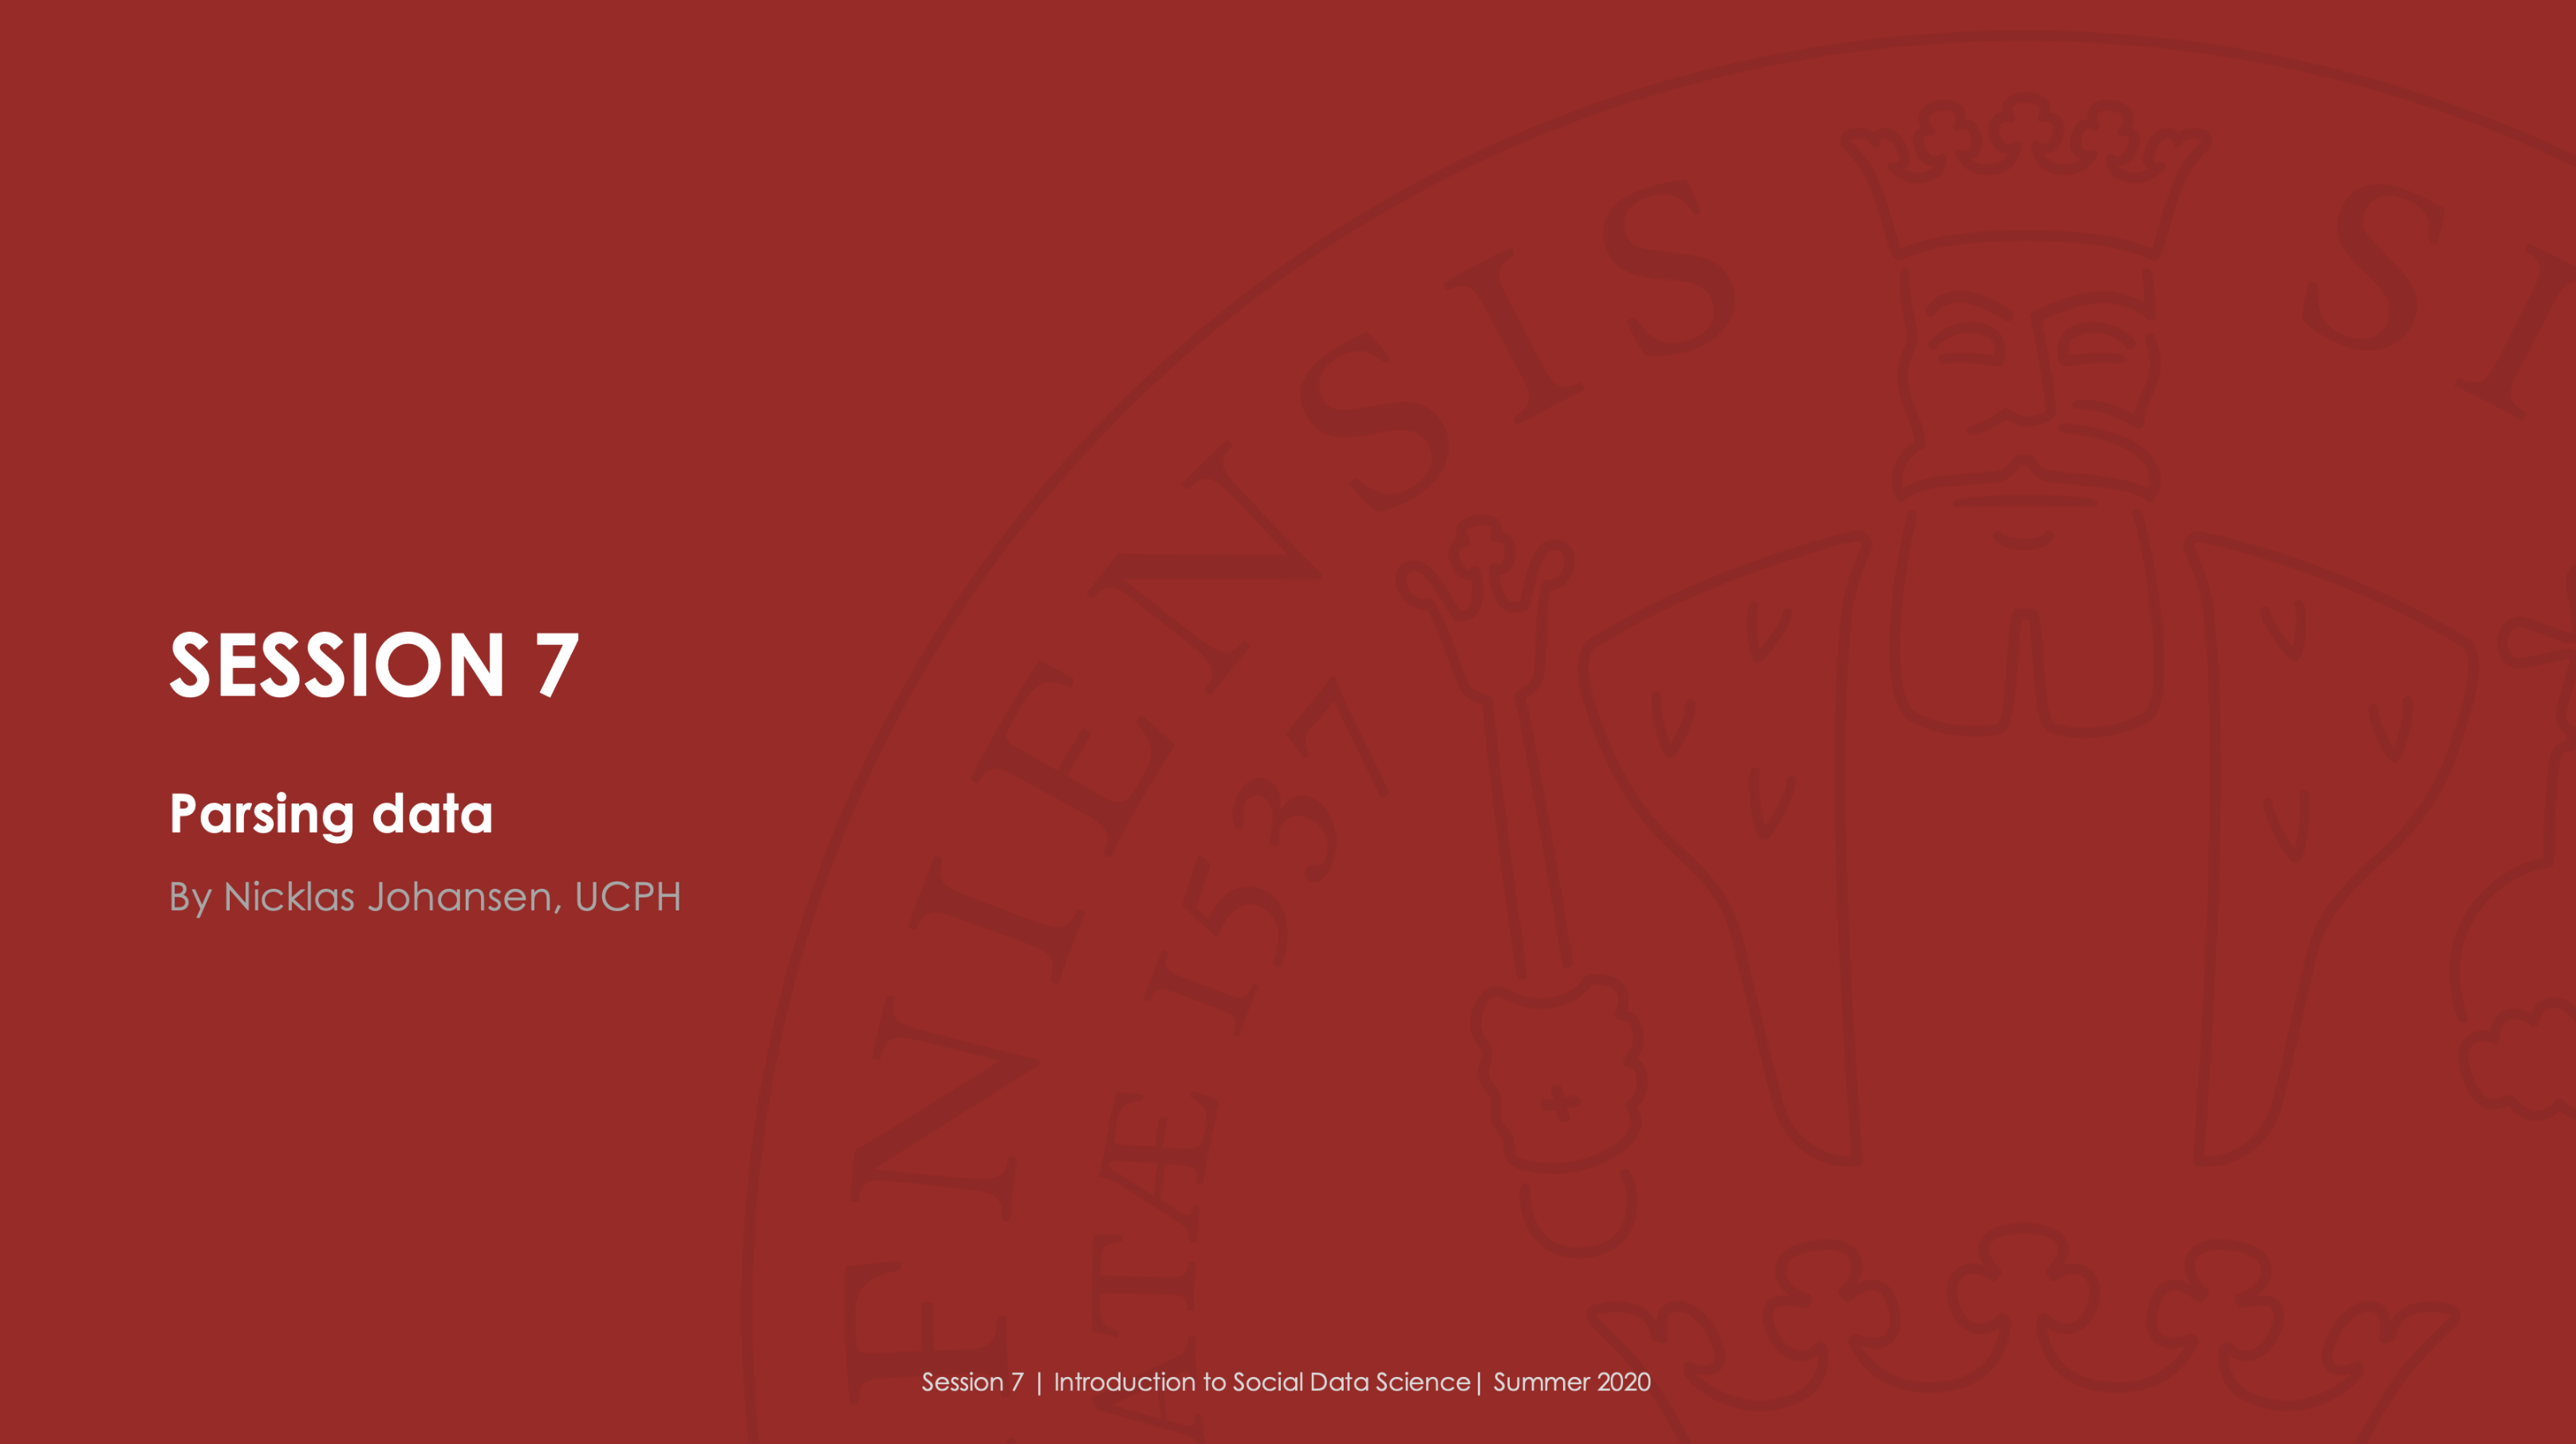

# Session 7: Parsing data

Yesterday I gave you some powerful tricks. Tricks that will work when the data is already shipped in a neat format. However this is not the rule. Today we shall learn the art of parsing unstructured text and a more principled and advanced method of parsing HTML.

This will help you build ***custom datasets*** within just a few hours or days work, that would have taken ***months*** to curate and clean manually.

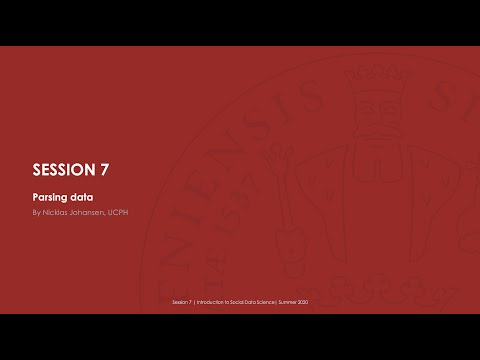

In [281]:
from IPython.display import YouTubeVideo
YouTubeVideo('wQ9CJ8wFO88', width=640, height=360)

In [283]:
# pregnananant
# YouTubeVideo('EShUeudtaFg', width=320, height=180)

## Agenda

1. HTML structure and syntax
2. Parsing and cleaning raw data
3. Reading and writing of files
4. Visualizing our log

## The HTML Tree
HTML has a Tree structure. 

Each node in the tree has:
        - Children, siblings, parents - descendants. 
        - Ids and attributes

<img src="http://www.openbookproject.net/tutorials/getdown/css/images/lesson4/HTMLDOMTree.png"/>


## Important syntax and patterns
_______________
```html 
<p>The p tag indicates a paragraph <p/>
```
_______________
```html 
<b>The b tag makes the text bold, giving us a clue to its importance </b>
```
output: <b>The b tag makes the text bold, giving us a clue to its importance </b>
```html 

<em>The em tag emphasize the text</em>, giving us a clue to its importance
```
output: <em>The em tag makes emphasize the text</em>, giving us a clue to its importance
___________
```html 
<h1>h1</h1><h2>h2</h2><h2>h3</h3><b>Headers give similar clues</b>
```
output:
<h1>h1</h1><h2>h2</h2><h3>h3</h3><b>Headers give similar clues</b>
_________________
```html 
<a href="www.google.com">The a tag creates a hyperlink <a/>
```
output: <a href="www.google.com">The a tag creates a hyperlink <a/>
_____________
Finally you have the terrible and confusing iframe: 
```html
 <iframe src="https://www.google.com"></iframe>
```
_________________

## How do we find our way around this tree?
1. Regex: Extracting string patterns using .split and regular expresssions
2. CSS-selectors: Specifying paths using css-selectors, xpath syntax.
3. ```BeautifulSoup```: A more powerful and principled (+readable) way is to use the python module BeautifulSoup to parse and traverse the tree.

In [17]:
# scraping newspaper articles - regex
url = 'https://www.theguardian.com/us-news/2019/aug/14/taco-eating-contest-death-fresno-california'
response,call_id = connector.get(url,'test_call')
html = response.text
html.split('\n')

['',
 '<!DOCTYPE html>',
 '<html id="js-context" class="js-off is-not-modern id--signed-out" lang="en" data-page-path="/us-news/2019/aug/14/taco-eating-contest-death-fresno-california">',
 '<head>',
 '<!--',
 '     __        __                      _     _      _',
 '     \\ \\      / /__    __ _ _ __ ___  | |__ (_)_ __(_)_ __   __ _',
 "      \\ \\ /\\ / / _ \\  / _` | '__/ _ \\ | '_ \\| | '__| | '_ \\ / _` |",
 '       \\ V  V /  __/ | (_| | | |  __/ | | | | | |  | | | | | (_| |',
 '        \\_/\\_/ \\___|  \\__,_|_|  \\___| |_| |_|_|_|  |_|_| |_|\\__, |',
 '                                                            |___/',
 '    Ever thought about joining us?',
 '    https://workforus.theguardian.com/careers/digital-development/',
 '     --->',
 '<title>Man dies after taco-eating contest in California | US news | The Guardian</title>',
 '<meta charset="utf-8">',
 '<meta name="description" content="Fresno Grizzlies ‘devastated to learn’ of Dana Hutchings’ death following event at mi

### CSS Selectors 

- Another way to browse through the HTML tree
- Define a unique path to an element in the HTML tree.
- It is quick but has to be hardcoded and also more likely to break.


## Parsing HTML with BeautifulSoup
BeautifulSoup makes the html tree navigable. 
It allows you to:
    * Search for elements by tag name and/or by attribute.
    * Iterate through them, go up, sideways or down the tree.
    * Furthermore it helps you with standard tasks such as extracting raw text from html,
    which would be a very tedious task if you had to hardcode it using `.split` commands and using your own regular expressions will be unstable.

In [42]:
# scraping newspaper articles example.
connector = Connector('log_isds_lecture_7.csv')
url = 'https://www.theguardian.com/us-news/2019/aug/14/taco-eating-contest-death-fresno-california'
response,call_id = connector.get(url,'test_call')
html = response.text

In [41]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html,'lxml') # parse the raw html using BeautifoulSoup

In [34]:
# extract hyperlinks
links = soup.find_all('a') # find all a tags -connoting a hyperlink.
[link['href'] for link in links if link.has_attr('href')][0:5] # unpack the hyperlink from the a nodes.

['#maincontent',
 'https://www.theguardian.com/international',
 'https://support.theguardian.com/contribute?INTCMP=header_support_contribute&acquisitionData=%7B%22componentType%22:%22ACQUISITIONS_HEADER%22,%22componentId%22:%22header_support_contribute%22,%22source%22:%22GUARDIAN_WEB%22%7D',
 'https://support.theguardian.com/subscribe?INTCMP=header_support_subscribe&acquisitionData=%7B%22componentType%22:%22ACQUISITIONS_HEADER%22,%22componentId%22:%22header_support_subscribe%22,%22source%22:%22GUARDIAN_WEB%22%7D',
 'https://support.theguardian.com/contribute?INTCMP=header_support_contribute&acquisitionData=%7B%22componentType%22:%22ACQUISITIONS_HEADER%22,%22componentId%22:%22header_support_contribute%22,%22source%22:%22GUARDIAN_WEB%22%7D']

In [8]:
headline = soup.find('h1') # search for the first headline: h1 tag. 
name = headline['class'][0].strip() # use the class attribute name as column name.
value = headline.text.strip() # extract text using build in method.
print(name,':',value)

content__headline : Man dies after taco-eating contest in California


In [36]:
article_text = soup.find('div',{'class':'content__article-body from-content-api js-article__body'}).text # find the content.


Say we are interested in how articles cite sources to back up their story i.e. their hyperlink behaviour within the article, and we want to see if the media has changed their behaviour.

We know how to search for links. But the cool part is that we can search from anywhere in the HTML tree. This means that once we have located the article content node - as above - we can search from there. This results in hyperlinks used within the article text.


In [40]:
# find the article_content node
article_content = soup.find('div',{'class':'content__article-body from-content-api js-article__body'})
# find citations within the article content.
citations = article_content.find_all('a')

In [38]:
citation_links = [] # define container to the hyperlinks
for citation in citations: # iterate through each citation node
    if citation.has_attr('data-link-name'): # check if it has the right attribute
        if citation['data-link-name'] =='in body link': # and if the value of that attribute is correct
            #print(citation['href'])
            citation_links.append(citation['href']) #  add link to the container

In [39]:
citation_links

['https://www.theguardian.com/us-news/gallery/2016/jul/04/nathans-famous-hotdog-eating-contest-in-pictures']

## Another example: bold.dk
### Let's put together some of the stuff we have learned so far
1. **Investigate:** In this example we will try to investigate the website to uderstand its structure. 
2. **Mapping:** Then we will try to collect all the urls and save them into a list
3. **Parsing:** At last, we will try to collect the information in each url in a simpel loop.

#### How to identify one url

In [164]:
# define our URL
url = 'https://www.bold.dk/' 

# connects to site
response = connector.get(url,'bold.dk') # 

# parse data with BeautifulSoup
soup = BeautifulSoup(response[0].text,'lxml') # parse the HTML

#identify news articles while inspecting site
articles = soup.find_all('div',{'class':'news_list_item'}) # search for the ul node

# one way to check if we find the right content
#print(articles[0].text.strip())

# collecting URLs
article_url = articles[0].attrs['data-vr-contentbox-url']
print(article_url)


https://www.bold.dk/fodbold/nyheder/monaco-sender-kamil-glik-tilbage-til-serie-a/


#### Creating a list of all the urls

In [174]:
url = 'https://www.bold.dk/' 
response = connector.get(url,'bold.dk')
soup = BeautifulSoup(response[0].text,'lxml')
articles = soup.find_all('div',{'class':'news_list_item'})

#create an empty list
list_of_article_urls = []

# creating a loop that appends the article url to the list above
for article in range(len(articles)):
    list_of_article_urls.append(articles[article].attrs['data-vr-contentbox-url'])

#printing the list
#list_of_article_urls[0:]

#printing one example
print(list_of_article_urls[0])

https://www.bold.dk/fodbold/nyheder/monaco-sender-kamil-glik-tilbage-til-serie-a/


#### Scraping each site from the url list

In [182]:
# creatig empty list for the infomation we want to extract for every article
h1_list = []
time_posted = []

for url in range(10): #len(list_of_article_urls)
    
    # this time we scrape for each news article in the url list we created before
    url = list_of_article_urls[url]
    response = connector.get(url,'bold.dk')
    soup = BeautifulSoup(response[0].text,'lxml')
    
    # now we can find the infromation we want on the articles and append them to our lists
    temp_1 = soup.find_all('h1')
    temp_1 = temp_1[1]
    temp_1 = temp_1.text.strip()
    h1_list.append(temp_1)
    
    temp_2 = soup.find_all('time')
    temp_2 = temp_2[0]
    temp_2 = str(temp_2)[16:32]
    time_posted.append(temp_2)

#### Putting it into a dataframe

In [264]:
import pandas as pd
df = pd.DataFrame({'title':h1_list, 'time':time_posted})
df

,title,time
0,Monaco sender Kamil Glik tilbage til Serie A,2020-08-11 20:41
1,Ung Gent-bomber skifter til Lille,2020-08-11 20:20
2,Southampton henter Tottenham-back,2020-08-11 20:02
3,Højbjerg: Jeg føler mig heldig og stolt,2020-08-11 19:35
4,Officielt: Højbjerg skifter til Tottenham,2020-08-11 19:03
5,Duo er færdig i Hobro,2020-08-11 18:55
6,Immobile: Vildt at slå Messi og Ronaldo-stime,2020-08-11 18:28
7,Real Madrid sender Areola tilbage til Paris,2020-08-11 18:05
8,CL-kvalifikationskamp aflyst grundet corona,2020-08-11 17:49
9,Johnsson: Nok min personlige rekord,2020-08-11 17:41


In [268]:
# saving df
df.to_csv('df_bold.dk.csv')

# loading df
pd.read_csv('df_bold.dk.csv', index_col=0)

,title,time
0,Monaco sender Kamil Glik tilbage til Serie A,2020-08-11 20:41
1,Ung Gent-bomber skifter til Lille,2020-08-11 20:20
2,Southampton henter Tottenham-back,2020-08-11 20:02
3,Højbjerg: Jeg føler mig heldig og stolt,2020-08-11 19:35
4,Officielt: Højbjerg skifter til Tottenham,2020-08-11 19:03
5,Duo er færdig i Hobro,2020-08-11 18:55
6,Immobile: Vildt at slå Messi og Ronaldo-stime,2020-08-11 18:28
7,Real Madrid sender Areola tilbage til Paris,2020-08-11 18:05
8,CL-kvalifikationskamp aflyst grundet corona,2020-08-11 17:49
9,Johnsson: Nok min personlige rekord,2020-08-11 17:41


## Storage
**For quality** 
- interactive process of improvements.
- quality assessment based on the log is easier with the raw html responses stored.

**For replicability**
- documentation and transparancy

In [269]:
# start by defining a Project name
project = 'erc_funding'


# os is a generel package for interacting with the system
### among other things automate folder creation
import os


## create folder if it does not not exist
if not os.path.isdir(project):
    os.mkdir(project)

subfolders = ['/mapping','/raw_data','/parsed_data']

# creating subfolders
for directory in subfolders: 
    if not os.path.isdir(directory):
        os.mkdir(project+directory) 


FileExistsError: [Errno 17] File exists: 'erc_funding/mapping'

## Reading and Writing

### Text Encoding - from 0's and 1's to signs and letters.

- utf-8 
    - Most widely used standard that also handles emojiis 
- but others are also used so we need to be aware.

In [186]:
# use the codecs module instead of open
##f = open('testfile','w')
import codecs
f = codecs.open('testfile','w','utf-8') # open command with a specified encoding.
f.write('😋 😎 😍 ')

### if encoding error happens anyways use the `ftfy`-package

In [187]:
with open('encodingerror','w') as f:
    f.write('æøåáé'.encode('utf-8').decode('latin1'))

In [189]:
import ftfy
with open('encodingerror','r') as f:
    
    s = f.read()
    print(s) # print the encoding error
    print(ftfy.fix_text(s)) ## ftfy fixes the encoding error

Ã¦Ã¸Ã¥Ã¡Ã©
æøåáé


## Storage formats
- json
     - Works as a dictionary (almost). Good for adding metadata to each data point
- multiple stacked json files.
    - json strings seperated by e.g. '\n\r'. 
    - Good for large projects

## Reading and Writing files from a folder

### ERC example
Imagine we wanted to analyze whether the European funding behaviour was biased towards certain countries and gender. We might decide to scrape who has received funding from the ERC.
https://erc.europa.eu/

* First we figure find navigate the grant listings.
* Next we figure out how to page these results. 
* And finally we want to grab the information.


In [270]:
# mapping
from tqdm import tqdm_notebook as tqdm # Module for tracking progress. conda install -c conda-forge tqdm
connector = Connector('erc_log.csv',overwrite_log=True)

base_url = 'https://erc.europa.eu/projects-figures/erc-funded-projects/results?items_per_page=100&search_api_views_fulltext=&'
n_pages = 10004//100+1
for i in tqdm(range(0,n_pages)):
    # define the url
    url = base_url+'page=%d'%i
    # download the url
    response,call_id = connector.get(url,'erc_mapping')
        
    ## dump the raw html response
    file_path = project+'/mapping'+'/%d'%call_id
    with codecs.open(file_path,'w','utf-8') as f:
        f.write(response.text)

/Users/nicklasjohansen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


## Parsing the results

In [271]:
## First we list the files
import os
path = project+'/mapping/'
files = [path+filename for filename in os.listdir(path)]
print(len(files))

101


In [272]:
## Start with a random page and create a parsing scheme
import random 
filename = random.choice(files)
filename

'erc_funding/mapping/51'

In [273]:
## read the file
with codecs.open(filename,'r','utf-8') as f:
    html = f.read()

In [274]:
## load the raw html into a Beautifulsoup object
from bs4 import BeautifulSoup
import bs4

In [275]:
import pandas as pd
def parse_erc(filename):
    # read the file
    with codecs.open(filename,'r','utf-8') as f:
        html = f.read()
    # turn raw string into a navigable html tree.
    soup = BeautifulSoup(html,'lxml')
    # find result list.
    result_list = soup.find('div',{'class':'view-content'}) # find elements using tag name and class attribute
    # loop through the "children" nodes of the result list node.
    data = [] # define container for the parsed datapoints
    for child in result_list.children:
        if type(child)==bs4.NavigableString: #check if it is a string or a html node. 
            continue # If it is a string the next part of the loop will be skipped.
            
        # the "child" is now the node containing the ERC research project information.
        ## structured as a pseudo table with rows containing a title and a value. 
        # define datapoint container
        d = {}
        # iterate through the content of the "pseudo" table.
        for grand_child in child.children:
            if type(grand_child)==bs4.NavigableString:
                continue # same procedure
            # use the span tag as separator between the column name and the value.
            spans = grand_child.findAll('span')
            # setup two different conditions.
            if len(spans)==2:
                key,value = spans
            else: # special case.
                key,value = [i for i in list(grand_child.find('span').children) if not type(i)==bs4.NavigableString]
            # add the datapoint to the it to the data container `d`
            d[key.text] = value.text # get the text of the two nodes using the object specific method .text        
            # Using the strong tag to find Founding amount in the raw summary text.
            ### The strong tag is a general heuristic.
            strong = grand_child.findAll('strong') # using the findAll method to locate the text marked with the 'strong' tag 
            if len(strong)>0: # check if node contains the strong tag.
                for node in strong: # if so iterate through it.
                    key = node.text # get the text
                    value = str(node.next.next) # get the value using the heuristic that 
    #                print(key,node.next,value)
                    d[key] = value
        # clean values for whitespace
        d = {key:value.strip() for key,value in d.items()}
        # add meta data for merging with the log
        d['filename'] = filename
        data.append(d) # append it to the data container.
    # convert to dataframe
    df = pd.DataFrame(data)
    return df


In [276]:
# run it on all pages
# import tqdm for monitoring the progress.
from tqdm import tqdm_notebook as tqdm
dfs = []
for filename in tqdm(files):
    dfs.append(parse_erc(filename))
df = pd.concat(dfs)

/Users/nicklasjohansen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


## Reliability and Data quality (1)
** For the Exam**: Dedicate a Notebook to the analysis of data quality

### Inspect the data
- Does the number of data point match our expectation?
- Counting Nan values and empty strings
- Do Random Inspections

In [277]:
## RANDOM INSPECTION
df.sample(10)

,Project acronym,Project,Researcher (PI),Host Institution (HI),Call Details,Summary,\r\n Summary\r\n,Max ERC Funding,Duration,filename
81,SEMANTAX,Form-Independent Semantics for Natural Languag...,Mark STEEDMAN,THE UNIVERSITY OF EDINBURGH,"Advanced Grant (AdG), SH4, ERC-2016-ADG",The project addresses the most important open ...,The project addresses the most important open ...,1 996 792 €,"Start date: 2017-08-01, End date: 2022-07-31",erc_funding/mapping/90
84,RMGPP,Productivity and Development: The Ready-made G...,Christopher Woodruff,"THE CHANCELLOR, MASTERS AND SCHOLARS OF THE UN...","Advanced Grant (AdG), SH1, ERC-2014-ADG",Differences in productivity explain much of di...,Differences in productivity explain much of di...,1 983 400 €,"Start date: 2015-12-01, End date: 2020-11-30",erc_funding/mapping/87
14,COMANFLO,Computation and analysis of statistical soluti...,Siddhartha MISHRA,EIDGENOESSISCHE TECHNISCHE HOCHSCHULE ZUERICH,"Consolidator Grant (CoG), PE1, ERC-2017-COG",Entropy (admissible) weak solutions are widely...,Entropy (admissible) weak solutions are widely...,1 959 323 €,"Start date: 2018-08-01, End date: 2023-07-31",erc_funding/mapping/18
71,TeloRNAging,The role of damage-induced non coding RNA in t...,Fabrizio D'ADDA DI FAGAGNA,IFOM FONDAZIONE ISTITUTO FIRC DI ONCOLOGIA MOL...,"Advanced Grant (AdG), LS4, ERC-2018-ADG",Genome instability is a hallmark of cellular a...,Genome instability is a hallmark of cellular a...,2 497 500 €,"Start date: 2019-10-01, End date: 2024-09-30",erc_funding/mapping/100
77,INVESTIGERFE,Investigating the regulation of iron homeostas...,Léon Charles KAUTZ,INSTITUT NATIONAL DE LA SANTE ET DE LA RECHERC...,"Starting Grant (StG), LS4, ERC-2016-STG",The existence of an “erythron-related regulato...,The existence of an “erythron-related regulato...,1 499 235 €,"Start date: 2017-05-01, End date: 2022-04-30",erc_funding/mapping/51
35,CODEC,Consequences of Demographic Change,Arnstein Aassve,UNIVERSITA COMMERCIALE LUIGI BOCCONI,"Starting Grant (StG), SH1, ERC-2007-StG",The project will be using the Gender and Gener...,The project will be using the Gender and Gener...,750 000 €,"Start date: 2008-07-01, End date: 2013-06-30",erc_funding/mapping/17
58,SOSNA,Expressive Power of Tree Logics,Mikolaj Bojanczyk,UNIWERSYTET WARSZAWSKI,"Starting Grant (StG), PE6, ERC-2009-StG",Logics for expressing properties of labeled tr...,Logics for expressing properties of labeled tr...,799 920 €,"Start date: 2009-11-01, End date: 2014-10-31",erc_funding/mapping/94
3,INTELLICORR,Intelligent corrosion management underpinned b...,Anne NEVILLE,UNIVERSITY OF LEEDS,"Advanced Grant (AdG), PE8, ERC-2016-ADG",Our planet’s population will continue to grow ...,Our planet’s population will continue to grow ...,2 271 830 €,"Start date: 2017-07-01, End date: 2022-06-30",erc_funding/mapping/51
47,ATHEROPROTECT,Structure-Function Analysis of the Chemokine I...,Christian Weber,LUDWIG-MAXIMILIANS-UNIVERSITAET MUENCHEN,"Advanced Grant (AdG), LS4, ERC-2009-AdG",Atherosclerosis is characterized by chronic in...,Atherosclerosis is characterized by chronic in...,2 500 000 €,"Start date: 2010-04-01, End date: 2016-03-31",erc_funding/mapping/6
95,SIGNAL2THEHUB,Integrin: signalling from the tail and the hub,Reinhard Fässler,MAX-PLANCK-GESELLSCHAFT ZUR FORDERUNG DER WISS...,"Advanced Grant (AdG), LS3, ERC-2012-ADG_20120314","""Integrin-mediated cell adhesion is essential ...","""Integrin-mediated cell adhesion is essential ...",2 462 689 €,"Start date: 2013-03-01, End date: 2018-02-28",erc_funding/mapping/91


In [278]:
## ERC lists 10004
len(df), len(df.drop_duplicates())

(10100, 10100)

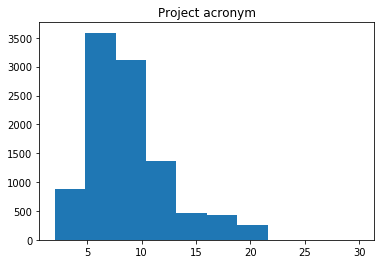

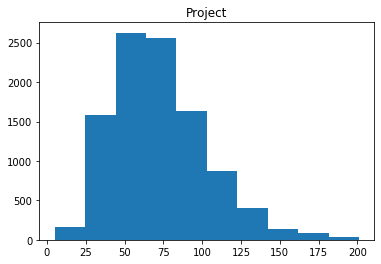

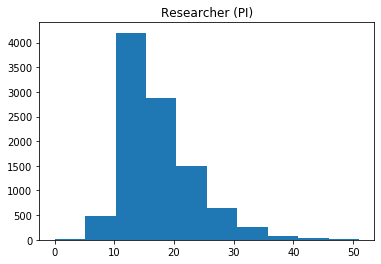

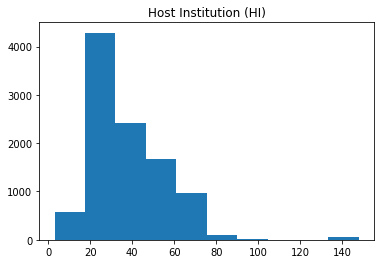

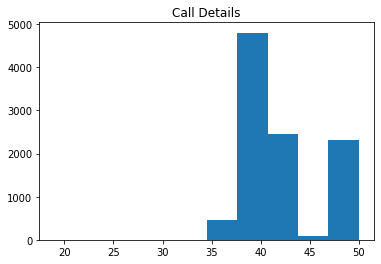

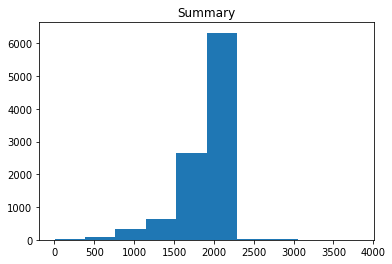

/Users/nicklasjohansen/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/nicklasjohansen/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


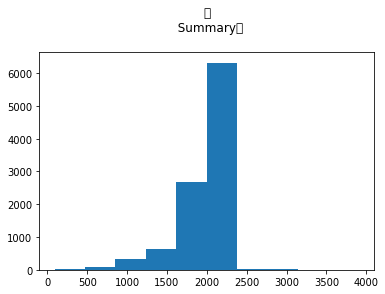

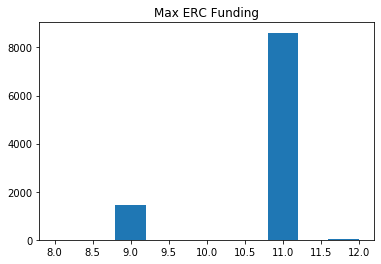

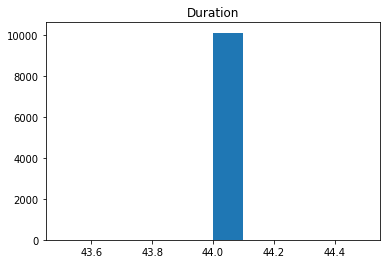

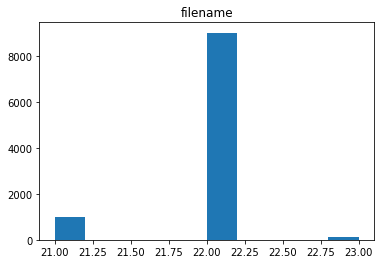

In [279]:
import matplotlib.pyplot as plt

## Count Nan values
df.apply(lambda x: x.isna().sum())

## Plot length of the String
for col in df.columns:
    plt.figure()
    plt.hist(df[col].fillna('').apply(len))
    plt.title(col)


### Do simple descriptives to see if everything make sense

In [221]:
df['Host Institution (HI)'].value_counts().head(15)

CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE CNRS                    522
THE CHANCELLOR, MASTERS AND SCHOLARS OF THE UNIVERSITY OF OXFORD     268
THE CHANCELLOR MASTERS AND SCHOLARSOF THE UNIVERSITY OF CAMBRIDGE    261
MAX-PLANCK-GESELLSCHAFT ZUR FORDERUNG DER WISSENSCHAFTEN EV          233
WEIZMANN INSTITUTE OF SCIENCE                                        189
EIDGENOESSISCHE TECHNISCHE HOCHSCHULE ZUERICH                        189
UNIVERSITY COLLEGE LONDON                                            185
ECOLE POLYTECHNIQUE FEDERALE DE LAUSANNE                             165
THE HEBREW UNIVERSITY OF JERUSALEM                                   131
IMPERIAL COLLEGE OF SCIENCE TECHNOLOGY AND MEDICINE                  128
INSTITUT NATIONAL DE LA SANTE ET DE LA RECHERCHE MEDICALE            119
LUDWIG-MAXIMILIANS-UNIVERSITAET MUENCHEN                             106
THE UNIVERSITY OF EDINBURGH                                          105
UNIVERSITEIT VAN AMSTERDAM                         

In [261]:
df['Researcher (PI)'].value_counts().head()

Martin O'HALLORAN          4
Klaus Pantel               4
Jacob KLEIN                4
Susana Marcos Celestino    4
Sandra Hirche              3
Name: Researcher (PI), dtype: int64

In [223]:
df['Project acronym'].value_counts().head()

INTERACT     9
SMART        6
COSMOS       5
IMAGINE      5
INTEGRATE    5
Name: Project acronym, dtype: int64

## Reliability and Data quality (2)
### Visualize the Log

In [232]:
# Load the LOG
import pandas as pd
log_df = pd.read_csv('erc_log.csv',sep=';') # load the ;-separated log 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [234]:
import datetime
# Convert the time column 't' to datetime 
#log_df['dt'] = log_df.t.apply(datetime.datetime.fromtimestamp)
log_df['dt'] = pd.to_datetime(log_df.t,unit='s')

In [235]:
dt = log_df.dt.values[0]

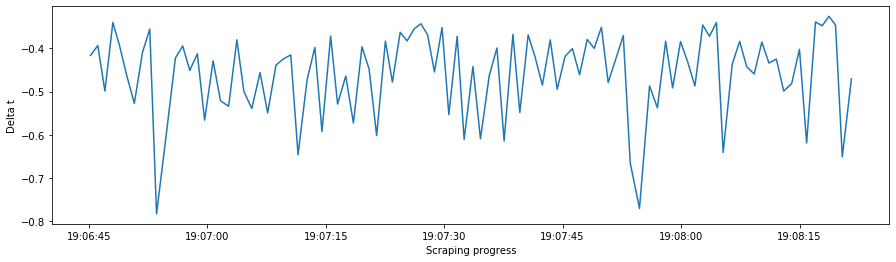

In [236]:
# Plot the time it took to make the call
plt.figure(figsize=(15,4))
plt.plot(log_df.dt,log_df.delta_t)
plt.ylabel('Delta t')
plt.xlabel('Scraping progress')
import datetime

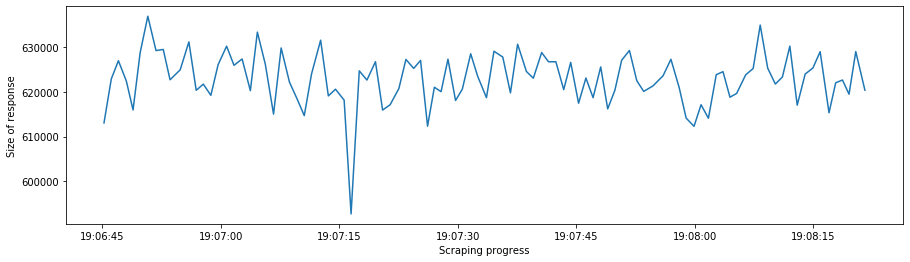

In [237]:
# Plot the response size over time.
plt.figure(figsize=(15,4))
plt.ylabel('Size of response')
plt.xlabel('Scraping progress')
plt.plot(log_df.dt,log_df.response_size)

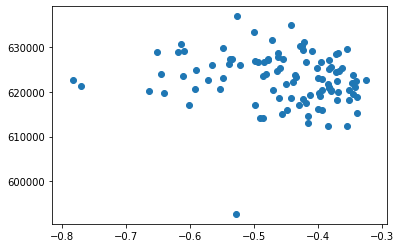

In [238]:
# Plot the delta_t against the response_size. These two should correlate pretty well.
plt.scatter(log_df.delta_t,log_df.response_size)

In [239]:
## Investigate errors
log_df.success.value_counts() ## Count errors
## Groupby time
# round the time for aggregation
log_df['dt_minute'] = log_df.dt.apply(lambda x: x-datetime.timedelta(seconds=x.second,microseconds=x.microsecond))
log_df['dt_hour'] = log_df.dt.apply(lambda x: x-datetime.timedelta(minutes=x.minute,seconds=x.second,microseconds=x.microsecond))
log_df.groupby('dt_hour').success.mean()


dt_hour
2020-08-11 19:00:00.000000001    True
2020-08-11 19:00:00.000000002    True
2020-08-11 19:00:00.000000004    True
2020-08-11 19:00:00.000000008    True
2020-08-11 19:00:00.000000011    True
                                 ... 
2020-08-11 19:00:00.000000992    True
2020-08-11 19:00:00.000000993    True
2020-08-11 19:00:00.000000995    True
2020-08-11 19:00:00.000000996    True
2020-08-11 19:00:00.000000999    True
Name: success, Length: 97, dtype: bool